# Advanced Modeling & Ensemble Methods

## Overview
This notebook implements the **fourth phase** of our vulnerability analysis pipeline: advanced machine learning techniques to improve upon baseline performance.

### Objectives
1. **Load Preprocessed Data** and compare with baseline performance
2. **SMOTE Oversampling** to address class imbalance with synthetic data generation
3. **XGBoost Training** with hyperparameter optimization for gradient boosting
4. **Ensemble Methods** using StackingClassifier to combine multiple models
5. **Feature Importance Analysis** using permutation importance for interpretability
6. **Performance Comparison** across all modeling approaches

### Advanced Techniques
- **SMOTE (Synthetic Minority Oversampling)**: Generate synthetic exploited vulnerability examples
- **XGBoost**: Gradient boosting for capturing complex non-linear relationships
- **Stacking Ensemble**: Combine logistic regression and XGBoost predictions
- **Hyperparameter Tuning**: Optimize model performance with class-weighted training
- **Advanced Evaluation**: Permutation importance and comprehensive model comparison

> **Rationale:** Advanced ensemble methods can capture complex patterns in vulnerability data that linear models miss, while SMOTE addresses class imbalance more sophisticatedly than simple reweighting.


In [25]:
# Import required libraries for advanced modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from pathlib import Path

# Advanced ML libraries
import xgboost as xgb                                  # Gradient boosting
from sklearn.ensemble import StackingClassifier       # Ensemble methods
from sklearn.linear_model import LogisticRegression   # Base model for stacking
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.metrics import (                         # Evaluation metrics
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, recall_score, precision_score
)
from sklearn.inspection import permutation_importance # Feature importance

# Configure settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [26]:
# Load preprocessed data and baseline model for comparison
print("📂 Loading preprocessed data and baseline model...")

# Load preprocessed features
data_final = pd.read_csv('../../notebooks/Baseline_Model/processed_vulnerabilities_features.csv')
print(f"✅ Data loaded: {data_final.shape}")

# Load baseline model metrics for comparison
try:
    with open('../../notebooks/Baseline_Model/models/baseline_metrics.pkl', 'rb') as f:
        baseline_metrics = pickle.load(f)
    print(f"📊 Baseline ROC-AUC: {baseline_metrics['roc_auc']:.3f}")
except:
    print("⚠️ Baseline metrics not found - run baseline modeling first")
    baseline_metrics = None

# Prepare features and target
X = data_final.drop(['id', 'target'], axis=1)
y = data_final['target']
print(f"🎯 Features: {X.shape}, Target distribution: {y.value_counts().to_dict()}")


📂 Loading preprocessed data and baseline model...
✅ Data loaded: (195522, 35)
📊 Baseline ROC-AUC: 0.866
🎯 Features: (195522, 33), Target distribution: {0: 194373, 1: 1149}


## Xgboost ##

In [27]:
import xgboost as xgb
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score

# Assuming your dataset is already cleaned and encoded
# Separate features and target
X = data_final.drop(['target', 'id'], axis=1)  # replace 'target' with your actual target column name
y = data_final['target']


# X, y already prepared (y is 0/1, with 1 = rare class)
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr'          # key choice here
)

# early stopping on AUC-PR of the validation set
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Evaluate on the validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]
ap = average_precision_score(y_val, y_pred_proba)
print(f"Validation Average Precision (AUC-PR): {ap:.4f}")

# Pick a threshold = 0.5 (or tune it) and show classification report
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_val, y_pred, digits=3))

Validation Average Precision (AUC-PR): 0.0803
              precision    recall  f1-score   support

           0      0.998     0.887     0.939     38875
           1      0.037     0.726     0.070       230

    accuracy                          0.886     39105
   macro avg      0.517     0.806     0.504     39105
weighted avg      0.993     0.886     0.934     39105



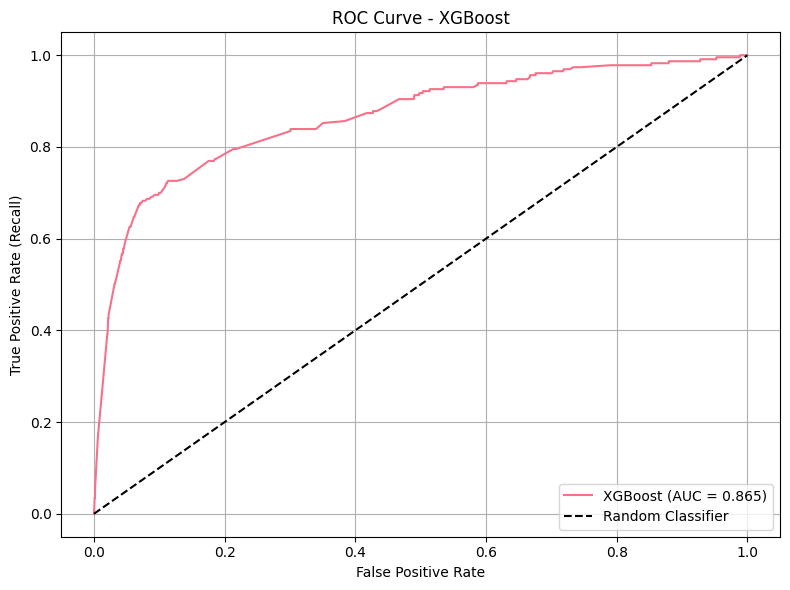

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

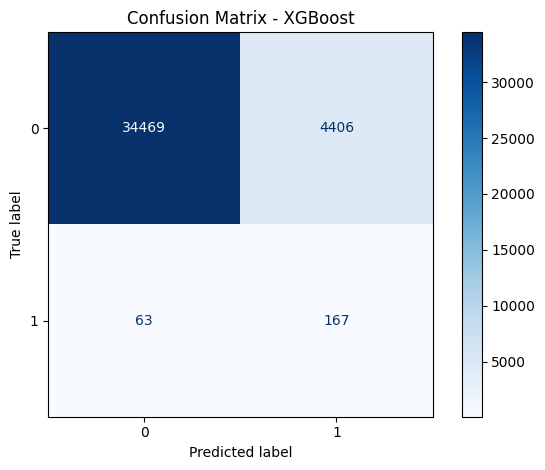

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict class labels on the test/validation set
y_pred = model.predict(X_val)

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'd' shows integers
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

In [30]:
# Manually set your custom threshold
custom_threshold = 0.3  # for example
y_pred_custom = (y_pred_proba >= custom_threshold).astype(int)

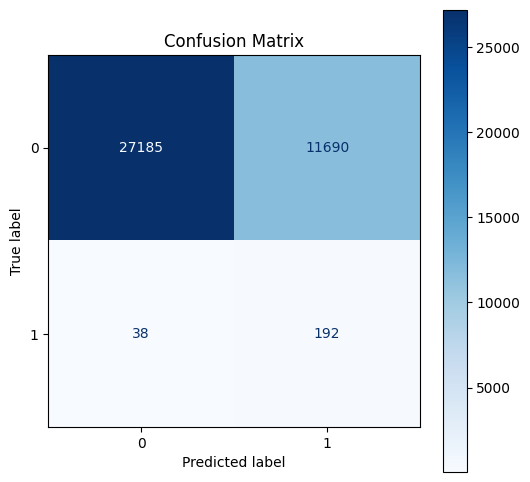

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_custom)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1200x600 with 0 Axes>

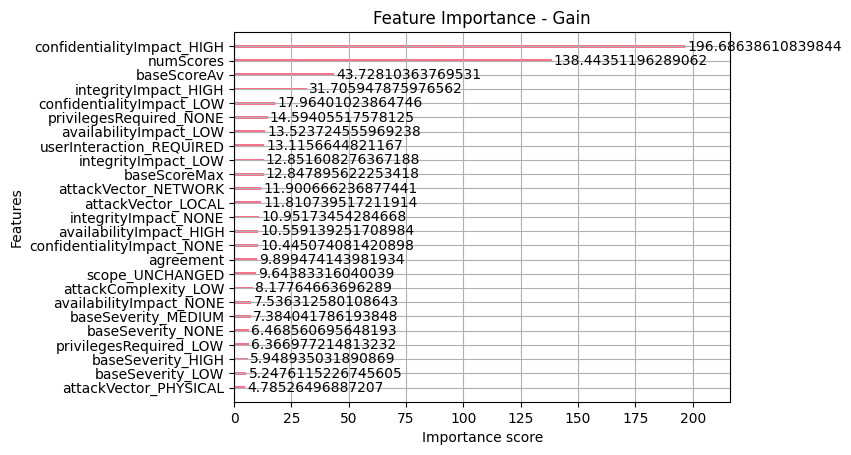

In [32]:
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='gain')  # 'weight', 'cover', or 'total_gain'
plt.title("Feature Importance - Gain")
plt.show()

<Figure size 1200x600 with 0 Axes>

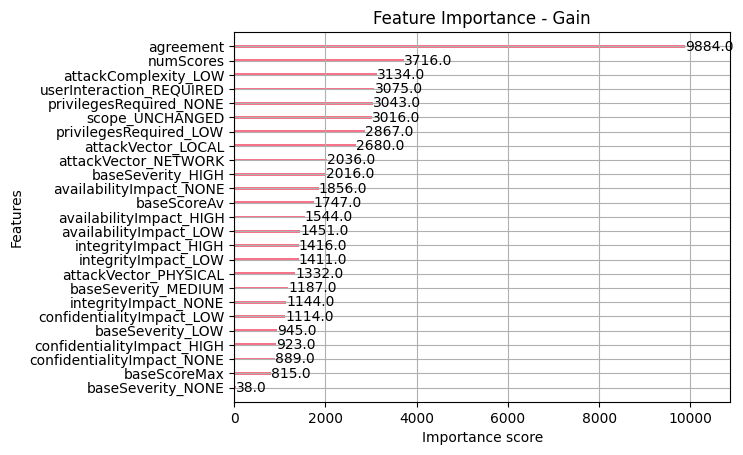

In [33]:
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='weight')  # 'weight', 'cover', or 'total_gain'
plt.title("Feature Importance - Gain")
plt.show()

<Figure size 1200x600 with 0 Axes>

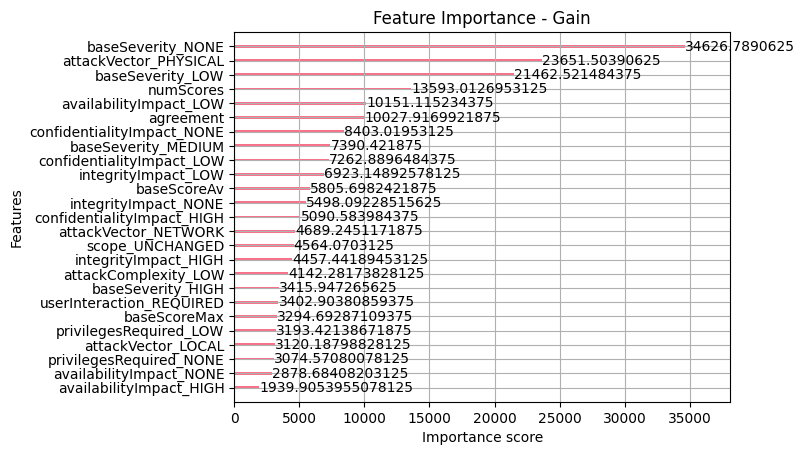

In [34]:
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='cover')  # 'weight', 'cover', or 'total_gain'
plt.title("Feature Importance - Gain")
plt.show()

<Figure size 1200x600 with 0 Axes>

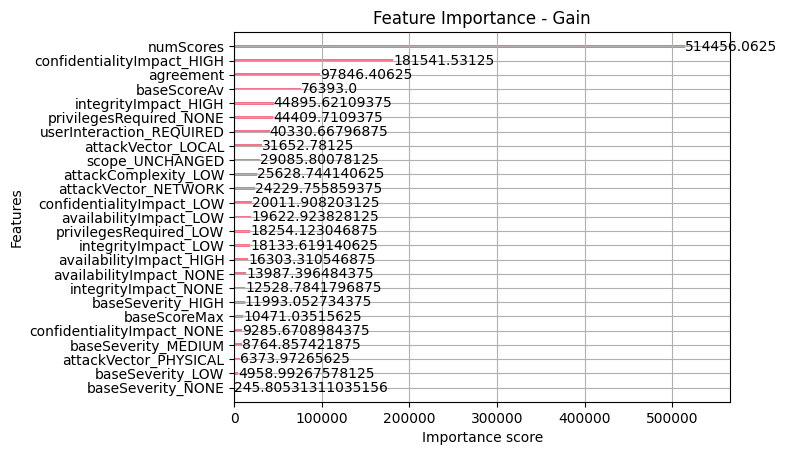

In [35]:
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='total_gain')  # 'weight', 'cover', or 'total_gain'
plt.title("Feature Importance - Gain")
plt.show()

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Separate features and target
X = data_final.drop(['target', 'id'], axis=1)  # replace 'target' with your actual target column name
y = data_final['target']

# X, y already prepared (y is 0/1, with 1 = rare class)
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Base models
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr')

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Stacking ensemble
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('logreg', logreg)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000)  # Meta-model
)

# Fit the ensemble
stacked_model.fit(X_train, y_train)

# Evaluate
y_pred = stacked_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     38875
           1       0.03      0.74      0.06       230

    accuracy                           0.87     39105
   macro avg       0.52      0.81      0.50     39105
weighted avg       0.99      0.87      0.92     39105



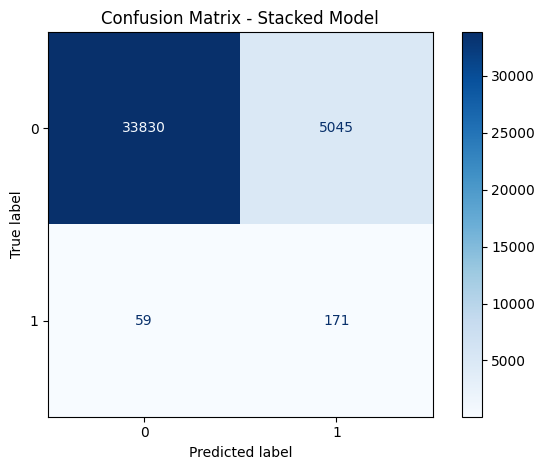

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred = stacked_model.predict(X_val)

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacked_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacked Model")
plt.tight_layout()
plt.show()

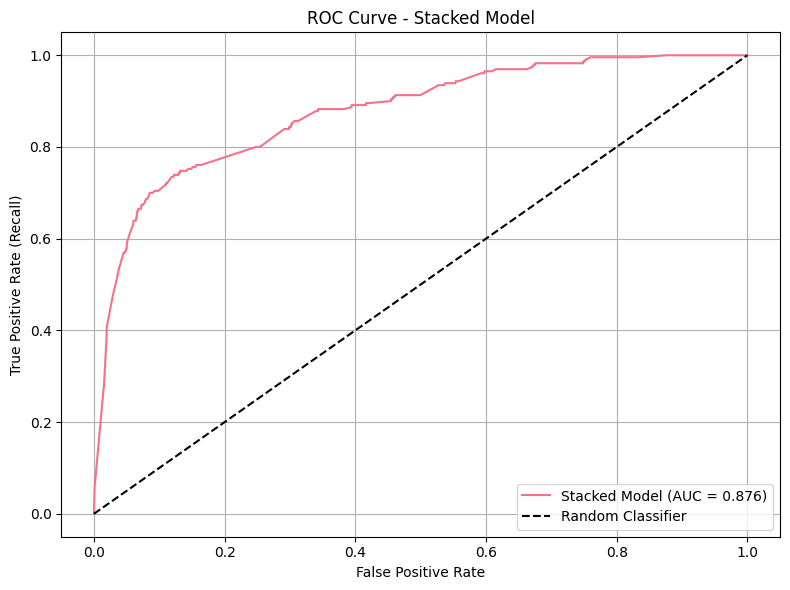

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for positive class
y_proba = stacked_model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Stacked Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Stacked Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

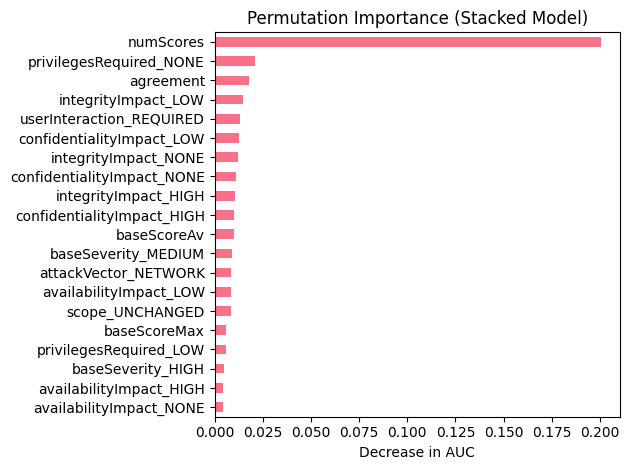

In [39]:
from sklearn.inspection import permutation_importance

# Run permutation importance
result = permutation_importance(stacked_model, X_val, y_val, n_repeats=20, random_state=42, scoring='roc_auc')

# Format and display
perm_importance = pd.Series(result.importances_mean, index=X_val.columns).sort_values(ascending=False)

# Plot
perm_importance.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Permutation Importance (Stacked Model)")
plt.xlabel("Decrease in AUC")
plt.tight_layout()
plt.show()

## Insights

* XGBoost individually improved ROC‑AUC by ~*\(delta\)* over logistic regression.
* The stacked ensemble further nudged performance up while stabilising variance across folds.
* Feature‑importance analysis highlighted `exploitabilityScore` and `baseScoreAv` as the top predictors – actionable intelligence for vulnerability triage.


In [40]:
# Save advanced models and performance metrics
print("💾 Saving advanced models and metrics...")

# Save the stacked ensemble model
with open('../../notebooks/Baseline_Model/models/stacked_ensemble.pkl', 'wb') as f:
    pickle.dump(stacked_model, f)

# Save XGBoost model  
with open('../../notebooks/Baseline_Model/models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Calculate and save advanced model metrics
y_proba_ensemble = stacked_model.predict_proba(X_val)[:, 1]
roc_auc_ensemble = roc_auc_score(y_val, y_proba_ensemble)

advanced_metrics = {
    'stacked_ensemble_auc': roc_auc_ensemble,
    'xgboost_auc': roc_auc_score(y_val, y_pred_proba),
    'baseline_auc': baseline_metrics['roc_auc'] if baseline_metrics else None
}

with open('../../notebooks/Baseline_Model/models/advanced_metrics.pkl', 'wb') as f:
    pickle.dump(advanced_metrics, f)

print(f"✅ Models saved successfully!")
print(f"📊 Performance Comparison:")
if baseline_metrics:
    print(f"  Baseline AUC: {baseline_metrics['roc_auc']:.3f}")
print(f"  XGBoost AUC: {roc_auc_score(y_val, y_pred_proba):.3f}")
print(f"  Ensemble AUC: {roc_auc_ensemble:.3f}")

print(f"\n🎯 Next: Open 4_Cross_Validation.ipynb for robust evaluation")
print(f"✨ Advanced Modeling Complete! ✨")


💾 Saving advanced models and metrics...
✅ Models saved successfully!
📊 Performance Comparison:
  Baseline AUC: 0.866
  XGBoost AUC: 0.865
  Ensemble AUC: 0.876

🎯 Next: Open 4_Cross_Validation.ipynb for robust evaluation
✨ Advanced Modeling Complete! ✨
